In [2]:
import sys
sys.path.append('../')
import torch
import os
import pandas as pd
import dataset_modules.common as common
from shutil import copyfile
import dataset_modules.one_part_dataset as one_part_dataset
import json
import metrics_helper
import numpy as np
from torch import Tensor
import matplotlib.pyplot as plt
import torchmetrics
import seaborn as sn

device_string = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_string)

if device_string == "cuda":
    print("Usando GPU!")

In [23]:
STATE_JSON = '../dataset_modules/state.json'
FRANCO_JSON = './nacho.json'

In [24]:
complaint_parts = common.load_complaint_parts('../preprocessing/piezas_normalizadas.csv', False, False)
def parts_from_complaint(complaint):
        df_complaint = complaint_parts[complaint_parts["DENUNCIA"] == complaint]
        return df_complaint["pieza_normalizada"].tolist()

with open(FRANCO_JSON) as f:
    franco = json.load(f)

In [25]:
franco

{'M204933/M204933002.jpg': {'selected_parts': [], 'class': 'broken'},
 'M245997/M245997001.jpg': {'selected_parts': [], 'class': 'broken'},
 'M275046/M275046003.jpg': {'selected_parts': [], 'class': 'broken'},
 'M275054/M275054007.jpg': {'selected_parts': [], 'class': 'broken'},
 'M275062/M275062002.jpg': {'selected_parts': [], 'class': 'not_broken'},
 'M275198/M275198002.jpg': {'selected_parts': [], 'class': 'broken'},
 'M275275/M275275002.jpg': {'selected_parts': [], 'class': 'broken'},
 'M275492/M275492004.jpg': {'selected_parts': [], 'class': 'not_broken'},
 'M292822/M292822003.jpg': {'selected_parts': [], 'class': 'not_broken'},
 'M297280/M297280004.jpg': {'selected_parts': [], 'class': 'not_broken'},
 'M297280/M297280005.jpg': {'selected_parts': [], 'class': 'not_broken'},
 'M300763/M300763007.jpg': {'selected_parts': [], 'class': 'not_broken'},
 'M300763/M300763008.jpg': {'selected_parts': [], 'class': 'not_broken'},
 'M301783/M301783002.jpg': {'selected_parts': [], 'class': 'no

In [26]:
result = {}

for key, value in franco.items():
    if value["class"] == "not_visible":
        continue
    
    is_broken = "Paragolpe Delantero" in parts_from_complaint(key.split("/")[0])
    result[key] = {
        "predicted": 1 if value["class"] == "broken" else 0, 
        "actual": 1 if is_broken else 0
    }
        
result

{'M204933/M204933002.jpg': {'predicted': 1, 'actual': 0},
 'M245997/M245997001.jpg': {'predicted': 1, 'actual': 0},
 'M275046/M275046003.jpg': {'predicted': 1, 'actual': 1},
 'M275054/M275054007.jpg': {'predicted': 1, 'actual': 1},
 'M275062/M275062002.jpg': {'predicted': 0, 'actual': 1},
 'M275198/M275198002.jpg': {'predicted': 1, 'actual': 0},
 'M275275/M275275002.jpg': {'predicted': 1, 'actual': 1},
 'M275492/M275492004.jpg': {'predicted': 0, 'actual': 0},
 'M292822/M292822003.jpg': {'predicted': 0, 'actual': 0},
 'M297280/M297280004.jpg': {'predicted': 0, 'actual': 0},
 'M297280/M297280005.jpg': {'predicted': 0, 'actual': 0},
 'M300763/M300763007.jpg': {'predicted': 0, 'actual': 0},
 'M300763/M300763008.jpg': {'predicted': 0, 'actual': 0},
 'M301783/M301783002.jpg': {'predicted': 0, 'actual': 1},
 'M301790/M301790007.jpg': {'predicted': 1, 'actual': 0},
 'M301976/M301976006.jpg': {'predicted': 1, 'actual': 1},
 'M302574/M302574003.jpg': {'predicted': 0, 'actual': 0},
 'M302857/M302

In [27]:
preds = []
targets = []
for key, value in result.items():
    preds.append(value["predicted"])
    targets.append(value["actual"])
    
preds_tensor = torch.IntTensor(preds)
targets_tensor = torch.IntTensor(targets)

In [28]:
metrics = metrics_helper.init_metrics(device, 2)
metrics(preds_tensor, targets_tensor)

metrics.compute()

{'confusion_matrix': tensor([[49., 15.],
         [19., 54.]]),
 'f1': tensor([0.7424, 0.7606]),
 'macro_acc': tensor(0.7527),
 'macro_f1': tensor(0.7515),
 'macro_prec': tensor(0.7516),
 'macro_rec': tensor(0.7527),
 'micro_acc': tensor(0.7518),
 'prec': tensor([0.7206, 0.7826]),
 'rec': tensor([0.7656, 0.7397])}

------------------------- GENERAL METRICS -------------------------

Loss 0.0
Micro Accuracy 0.7518247961997986
Macro Accuracy 0.7526755332946777
Macro Precision 0.7515984773635864
Macro Recall 0.7526755332946777
Macro F1 0.7514938116073608

------------------------- PER CLASS METRICS -------------------------


class  precision    recall        f1
0  not_broken   0.720588  0.765625  0.742424
1      broken   0.782609  0.739726  0.760563

<AxesSubplot:>

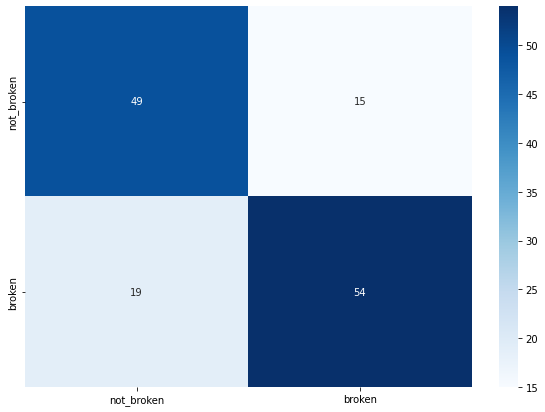

In [29]:
metrics_result = metrics.compute()
classes = ["not_broken", "broken"]
macro_metrics = metrics_helper.generate_macro_metrics(metrics_result, 0)
per_class_metrics = metrics_helper.generate_per_class_metrics(metrics_result, classes)

df_cm = pd.DataFrame(
    metrics_result['confusion_matrix'], 
    index = classes,
    columns = classes)

df_cm = df_cm.applymap(lambda x: x.item())

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [32]:
wrong_images = []

for key, value in result.items():
    if value["predicted"] == 0 and value["actual"] == 1:
        wrong_images.append(key)

len(wrong_images)

19

In [37]:
[print(x) for x in wrong_images]

M275062/M275062002.jpg
M301783/M301783002.jpg
M303793/M303793002.jpg
M303804/M303804007.jpg
M303937/M303937004.jpg
M303975/M303975002.jpg
M305984/M305984002.jpg
M306982/M306982002.jpg
M308851/M308851004.jpg
M310379/M310379004.jpg
M310379/M310379005.jpg
M312736/M312736005.jpg
M313745/M313745001.jpg
M313745/M313745002.jpg
M320157/M320157001.jpg
M321349/M321349006.jpg
M323037/M323037005.jpg
M323063/M323063004.jpg
M323832/M323832001.jpg


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

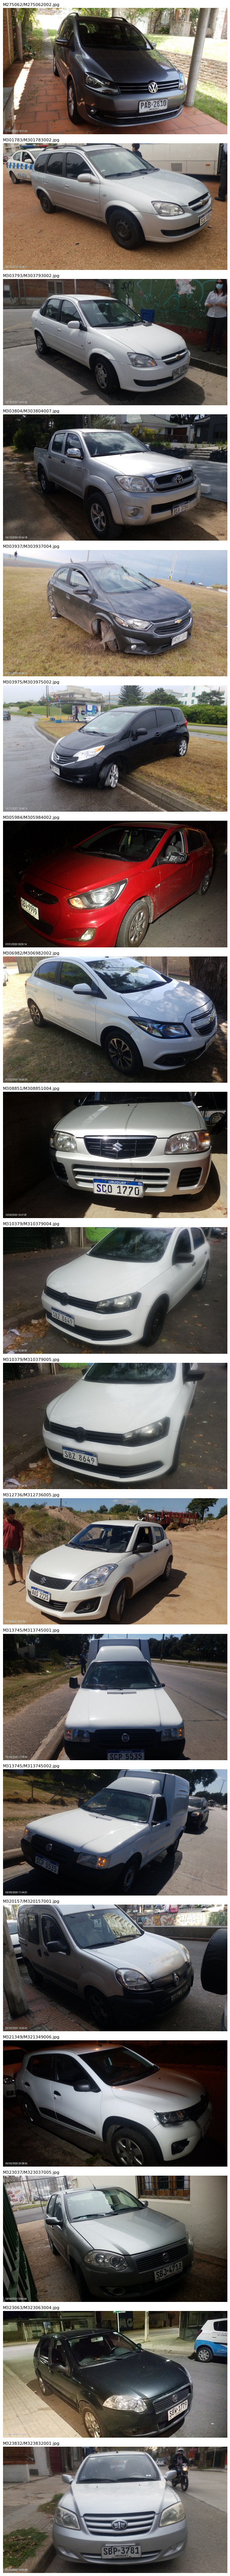

In [33]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image

N = len(wrong_images)
f = plt.figure(figsize=(8, 4.5*N), dpi=80)
count = 0

for img in wrong_images:
    
    f.add_subplot(N, 1, count+1)
    plt.text(0, -20, img)
    plt.imshow(to_pil_image(read_image('../dataset_modules/imgs/{}'.format(img))))
    plt.axis('off')
    
    count += 1
    
plt.tight_layout(); plt.show()